In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = ':https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F138%2F4508%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240530%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240530T052503Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1bcbce6914761984854c5621fed5961999b11ee2478eaa42e7f5eaf45af03c5846463b6be1bd5336a011f06e865b11aaf53a7779cea5e66c9ea2f3abdc55fad9bc6471800f1012837111e3f0642b190ef800542d2a2c2f4b2536defc75664ba840d59add88addcb2a70875728b0daf4fd1b817fece3c0420af353901bdaa7333f8d061f5f33ed4525a7f57867946daf0edeaeee4cfe19c46fe5ddec0a06611676a932cac2bc078581b77b52f903c5aceb05a8fe5c7414720f2a7b5253b5e337fcbbfb4dde956454dc20ca2301d6c4d20271e64c14cb540ba7e98ab3950a7db49840a975f40cab473bcd3265a08532008d45127d8f2e3bf3690c6ee35eeece6ad'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


## IMDb Genre based analysis
the following analysis take a quick look into specific genres

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
df = pd.read_csv('../input/tmdb_5000_movies.csv')

In [ ]:
df.head().T

,0,1,2,3,4
budget,237000000,300000000,245000000,250000000,260000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
homepage,http://www.avatarmovie.com/,http://disney.go.com/disneypictures/pirates/,http://www.sonypictures.com/movies/spectre/,http://www.thedarkknightrises.com/,http://movies.disney.com/john-carter
id,19995,285,206647,49026,49529
keywords,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...","[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...","[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...","[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...","[{""id"": 818, ""name"": ""based on novel""}, {""id"":..."
original_language,en,en,en,en,en
original_title,Avatar,Pirates of the Caribbean: At World's End,Spectre,The Dark Knight Rises,John Carter
overview,"In the 22nd century, a paraplegic Marine is di...","Captain Barbossa, long believed to be dead, ha...",A cryptic message from Bond’s past sends him o...,Following the death of District Attorney Harve...,"John Carter is a war-weary, former military ca..."
popularity,150.438,139.083,107.377,112.313,43.927
production_companies,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""name"": ""Walt Disney Pictures"", ""id"": 2}]"


## Data cleansing

In [ ]:
print('{:>28}'.format('entries from dataset:'), df.shape[0])
df = df.drop_duplicates(['original_title'])
print('{:>28}'.format('entries without duplicated:'), df.shape[0])
df_clean = df[['budget', 'genres', 'release_date', 'revenue']].dropna()
print('{:>28}'.format('entries from cleaned data:'), df_clean.shape[0])

       entries from dataset: 4803
 entries without duplicated: 4801
  entries from cleaned data: 4800


In [ ]:
df_clean.head(10).T

,0,1,2,3,4,5,6,7,8,9
budget,237000000,300000000,245000000,250000000,260000000,258000000,260000000,280000000,250000000,250000000
genres,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 14, ""name"": ""Fantasy""}, {""id"": 28, ""na...","[{""id"": 16, ""name"": ""Animation""}, {""id"": 10751...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...","[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...","[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam..."
release_date,2009-12-10,2007-05-19,2015-10-26,2012-07-16,2012-03-07,2007-05-01,2010-11-24,2015-04-22,2009-07-07,2016-03-23
revenue,2787965087,961000000,880674609,1084939099,284139100,890871626,591794936,1405403694,933959197,873260194


## Data preparation

In [ ]:
df_genre = pd.DataFrame(columns = ['genre', 'cgenres', 'budget', 'revenue', 'day', 'month', 'year'])

def dataPrep(row):
    global df_genre
    d = {}
    genres = np.array([g['name'] for g in eval(row['genres'])])
    n = genres.size
    d['budget'] = [row['budget']]*n
    d['revenue'] = [row['revenue']]*n
    d.update(zip(('year', 'month', 'day'), map(int, row['release_date'].split('-'))))
    d['genre'], d['cgenres'] = [], []
    for genre in genres:
        d['genre'].append(genre)
        d['cgenres'].append(genres[genres != genre])
    df_genre = df_genre.append(pd.DataFrame(d), ignore_index=True, sort=True)

df_clean.apply(dataPrep, axis=1)
df_genre = df_genre[['genre', 'budget', 'revenue', 'day', 'month', 'year', 'cgenres']]
df_genre = df_genre.infer_objects()

In [ ]:
df_clean[['genres', 'release_date']].head(2) # before data preparation

,genres,release_date
0,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",2009-12-10
1,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",2007-05-19


In [ ]:
df_genre[['genre', 'cgenres', 'year']].head(7) # after data preparation

,genre,cgenres,year
0,Action,"[Adventure, Fantasy, Science Fiction]",2009
1,Adventure,"[Action, Fantasy, Science Fiction]",2009
2,Fantasy,"[Action, Adventure, Science Fiction]",2009
3,Science Fiction,"[Action, Adventure, Fantasy]",2009
4,Adventure,"[Fantasy, Action]",2007
5,Fantasy,"[Adventure, Action]",2007
6,Action,"[Adventure, Fantasy]",2007


In [ ]:
print('{:>32}'.format('entries before data preparation:'), df_clean.shape[0])
print('{:>32}'.format('entries after data preparation:'), df_genre.shape[0])

entries before data preparation: 4800
 entries after data preparation: 12154


In [ ]:
df_genre.head(10).T

,0,1,2,3,4,5,6,7,8,9
genre,Action,Adventure,Fantasy,Science Fiction,Adventure,Fantasy,Action,Action,Adventure,Crime
budget,237000000,237000000,237000000,237000000,300000000,300000000,300000000,245000000,245000000,245000000
revenue,2787965087,2787965087,2787965087,2787965087,961000000,961000000,961000000,880674609,880674609,880674609
day,10,10,10,10,19,19,19,26,26,26
month,12,12,12,12,5,5,5,10,10,10
year,2009,2009,2009,2009,2007,2007,2007,2015,2015,2015
cgenres,"[Adventure, Fantasy, Science Fiction]","[Action, Fantasy, Science Fiction]","[Action, Adventure, Science Fiction]","[Action, Adventure, Fantasy]","[Fantasy, Action]","[Adventure, Action]","[Adventure, Fantasy]","[Adventure, Crime]","[Action, Crime]","[Action, Adventure]"


## Occurrences per genre

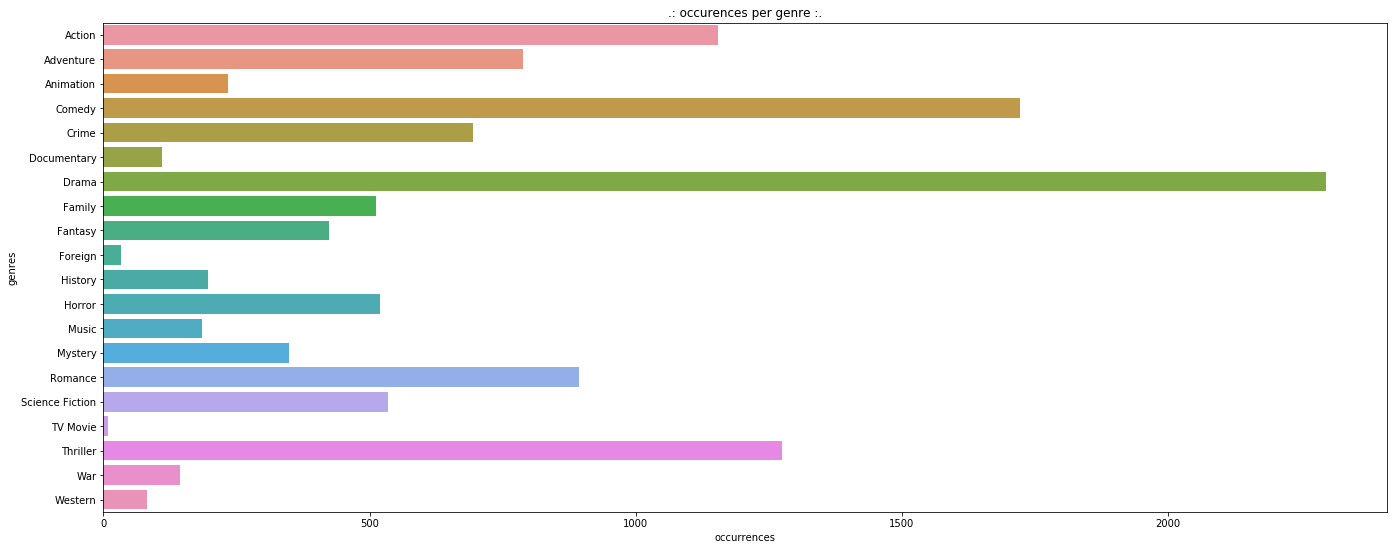

In [ ]:
genre_count = df_genre['genre'].value_counts().sort_index()
df_gCount = pd.DataFrame({'genre': genre_count.index, 'count': genre_count.values})
f, ax = plt.subplots(figsize=(23, 9))
sns.barplot(x = 'count', y = 'genre', data=df_gCount)
ax.set_title('.: occurences per genre :.')
ax.set_xlabel('occurrences')
ax.set_ylabel('genres')
plt.show()

## Money x Genre x Year

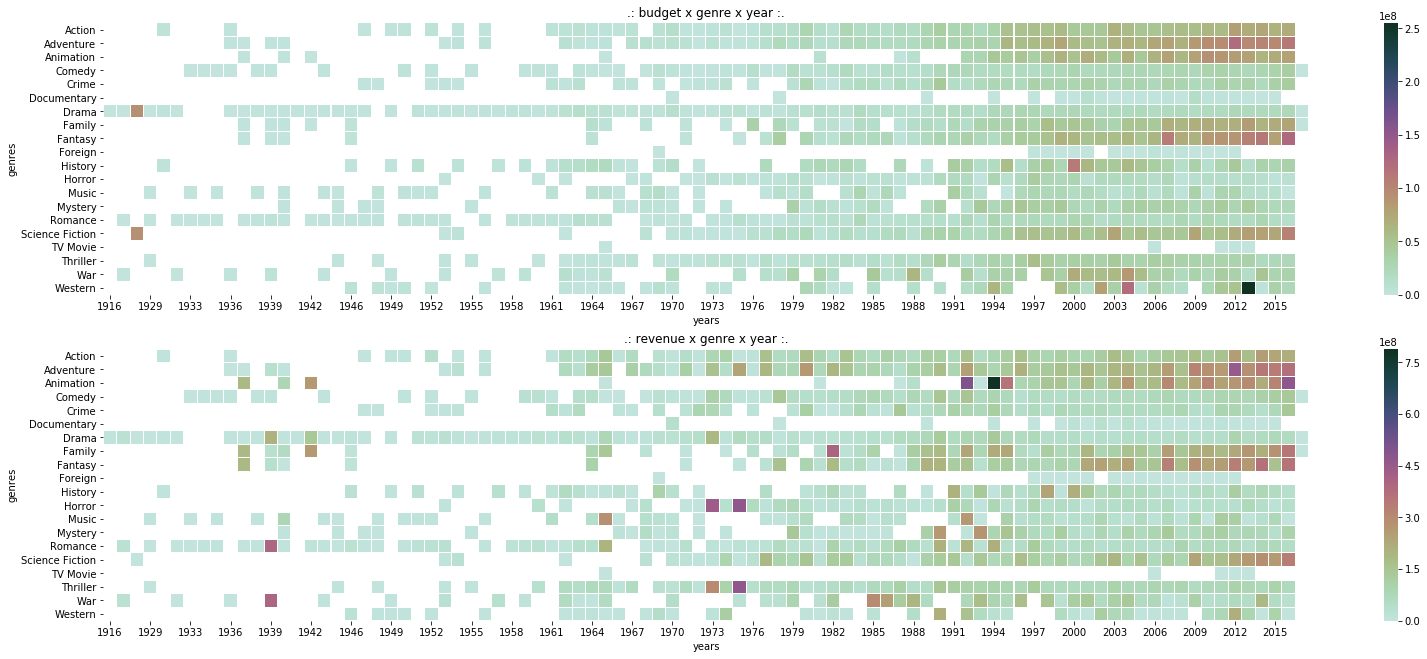

In [ ]:
genre_year = df_genre.groupby(['genre', 'year']).mean().sort_index()
df_gyBudget = genre_year.pivot_table(index=['genre'], columns=['year'], values='budget', aggfunc=np.mean)
df_gyGross = genre_year.pivot_table(index=['genre'], columns=['year'], values='revenue', aggfunc=np.mean)
f, [axA, axB] = plt.subplots(figsize=(27, 11), nrows=2)
cmap = sns.cubehelix_palette(start=1.5, rot=1.5, as_cmap=True)
sns.heatmap(df_gyBudget, xticklabels=3, cmap=cmap, linewidths=0.05, ax=axA)
sns.heatmap(df_gyGross, xticklabels=3, cmap=cmap, linewidths=0.05, ax=axB)
axA.set_title('.: budget x genre x year :.')
axA.set_xlabel('years')
axA.set_ylabel('genres')
axB.set_title('.: revenue x genre x year :.')
axB.set_xlabel('years')
axB.set_ylabel('genres')
plt.show()

## Connected genres

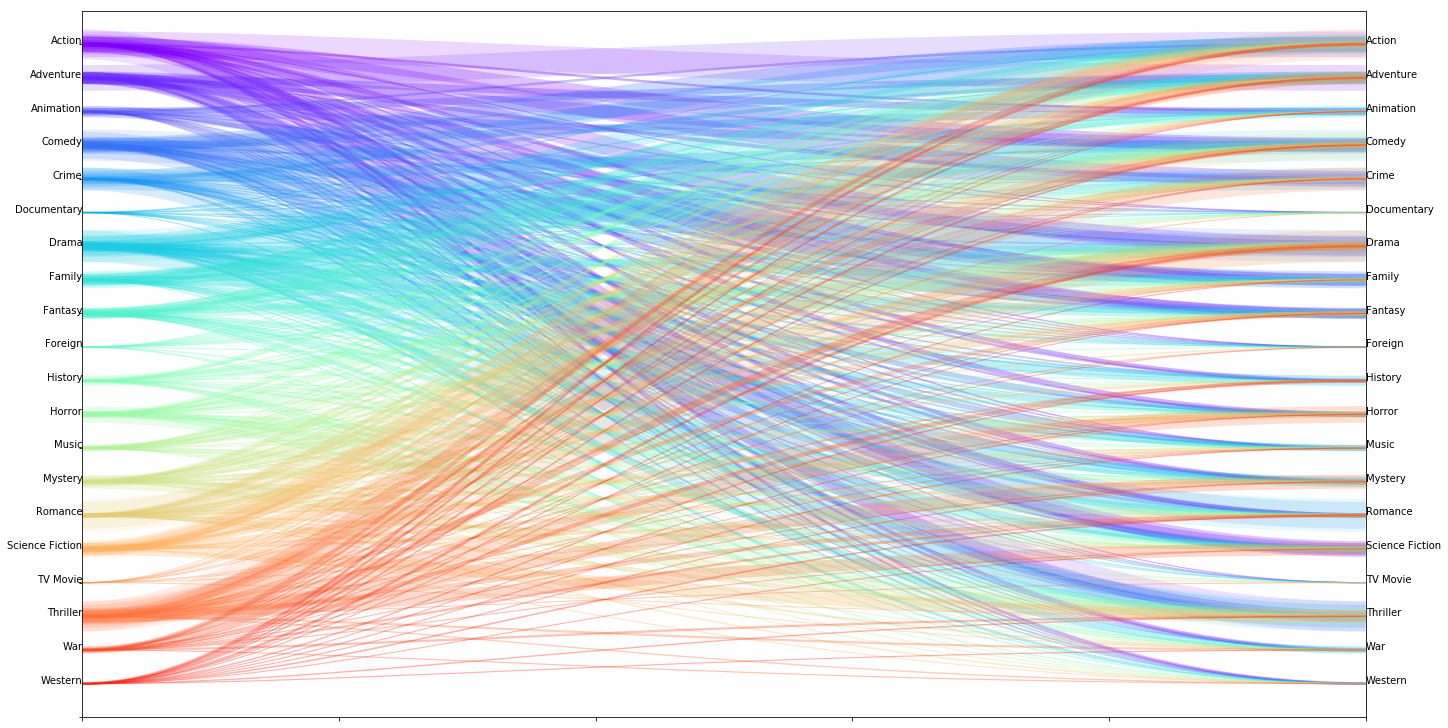

In [ ]:
####################
# make connections #
####################
d_genre = {}
def connect(row):
    global d_genre
    genre = row['genre']
    cgenres = row['cgenres']
    if genre not in d_genre:
        d_cgenres = dict(zip(cgenres, [1]*len(cgenres)))
        d_genre[genre] = d_cgenres
    else:
        for cgenre in cgenres:
            if cgenre not in d_genre[genre]:
                d_genre[genre][cgenre] = 1
            else:
                d_genre[genre][cgenre] += 1

df_genre.apply(connect, axis = 1)
l_genre = list(d_genre.keys())
l_genre.sort()
###########################
# find largest connection #
###########################
cmax = 0
for key in d_genre:
    for e in d_genre[key]:
        if d_genre[key][e] > cmax:
            cmax = d_genre[key][e]
#########################
# visualize connections #
#########################
from matplotlib.path import Path
import matplotlib.patches as patches
from matplotlib import cm
color = cm.get_cmap('rainbow')
f, ax = plt.subplots(figsize = (23, 13))

codes = [Path.MOVETO, Path.CURVE4, Path.CURVE4, Path.CURVE4]

X, Y = 1, 1
wmin, wmax = 1, 32
amin, amax = 0.1, 0.25
getPy = lambda x: Y*(1 - x/len(l_genre))
for i, genre in enumerate(l_genre):
    yo = getPy(i)
    ax.text(0, yo, genre, ha = 'right')
    ax.text(X, yo, genre, ha = 'left')
    for cgenre in d_genre[genre]:
        yi = getPy(l_genre.index(cgenre))
        verts = [(0.0, yo), (X/4, yo), (2*X/4, yi), (X, yi)]
        path = Path(verts, codes)
        r, g, b, a = color(i/len(l_genre))
        width = wmin + wmax*d_genre[genre][cgenre]/cmax
        alpha = amin + amax*(1 - d_genre[genre][cgenre]/cmax)
        patch = patches.PathPatch(path, facecolor = 'none', edgecolor = (r, g, b), lw = width, alpha = alpha)
        ax.add_patch(patch)

ax.grid(False)
ax.set_xlim(0.0, X)
ax.set_ylim(0.0, Y + 1/len(l_genre))
ax.set_yticklabels([])
ax.set_xticklabels([])
plt.show()